<a href="https://colab.research.google.com/github/fjgonzalezmgt/kidney_stones/blob/main/kidney_stones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identificación del Proyecto

**Autor:** [Francisco González](https://www.linkedin.com/in/franciscogonzalez/)  
**Especialidad:** Ingeniería Industrial, análisis de datos, aseguramiento de calidad.  
**Repositorio de dataset utilizado:** [Kidney Stone Images Dataset (Kaggle)](https://www.kaggle.com/datasets/safurahajiheidari/kidney-stone-images)  
**Propósito del notebook:** Entrenar y evaluar un modelo YOLOv8 para la detección automatizada de cálculos renales en imágenes médicas.

---

## ¿Qué es YOLO?

YOLO (*You Only Look Once*) es una familia de modelos de **detección de objetos en imágenes** basada en redes neuronales profundas. Su característica principal es que realiza la detección **en una sola pasada** por la imagen, lo que lo convierte en uno de los métodos más rápidos y eficientes para tareas de visión por computadora en tiempo real.

A diferencia de otros enfoques tradicionales que primero generan regiones de interés y luego clasifican, YOLO:
1. **Divide la imagen en una cuadrícula**  
2. **Predice simultáneamente**:  
   - La clase del objeto  
   - La probabilidad de que exista objeto en cada celda  
   - Las coordenadas del *bounding box*  
3. Produce detecciones en tiempo real con alta precisión.

Actualmente existen varias versiones de YOLO (v1, v2, v3, v4, v5, v7, v8…). En este proyecto se utiliza **Ultralytics YOLOv8**, que incluye mejoras en:
- Arquitectura del modelo, más ligera y eficiente  
- Aumento de datos incorporado  
- Soporte para entrenamiento, validación, inferencia, exportación  
- Métricas estandarizadas como mAP, precision, recall  
- Uso simple desde Python o CLI  

---

## Descripción del Dataset

El dataset utilizado contiene imágenes de procedimientos médicos donde se observan **cálculos renales (piedras)** capturados mediante endoscopía o litotricia. El objetivo es que el modelo detecte la piedra dentro del campo visual y la delimite con un cuadro.

### Estructura del dataset

```

data/
└── kidney_stones/
├── train/
│   ├── images/
│   └── labels/
├── test/
│   ├── images/
│   └── labels/
├── data.yaml
├── README.dataset.txt
└── README.roboflow.txt

```

### Formato de anotaciones

Cada imagen tiene un archivo de texto `.txt` con el siguiente formato:

```

<class_id> <x_center> <y_center> <width> <height>

```

- Las coordenadas están **normalizadas** entre 0 y 1  
- `<class_id>` representa el tipo de objeto detectado  

En este caso solo existe **una clase**:

| ID | Clase     |
|----|-----------|
| 0  | `Tas_Var` |

### Distribución de los datos

| Subconjunto | Descripción |
|-------------|-------------|
| `train/`    | Imágenes para entrenamiento del modelo |
| `test/`     | Imágenes usadas únicamente para evaluar el desempeño final |

---

## Objetivo del Proyecto

Entrenar un modelo YOLOv8 capaz de:

1. Detectar automáticamente la presencia de un cálculo renal  
2. Delimitarlo correctamente usando un bounding box  
3. Mantener **alta precisión médica** (pocos falsos positivos)  
4. Ser lo suficientemente rápido como para usarse en aplicaciones clínicas o análisis automatizados  

---

Este notebook guiará todo el proceso:

1. Cargar y explorar el dataset  
2. Entrenar un modelo YOLOv8  
3. Validar su rendimiento usando métricas como `precision`, `recall`, `mAP`  
4. Ajustar umbrales de decisión (`conf`, `iou`)  
5. Visualizar y exportar resultados de detección  



In [1]:
# 1) Montar Drive y preparar rutas
from google.colab import drive
drive.mount('/content/drive')

# Ajusta esta ruta si tu carpeta no es exactamente "My Drive"
BASE = "/content/drive/My Drive/data/kidney_stones"
DATA_YAML = f"{BASE}/data.yaml"

# Carpeta donde guardar los resultados de entrenamiento
PROJECT_DIR = "/content/drive/My Drive/yolo_runs_kidney"
print("DATA_YAML:", DATA_YAML)
print("PROJECT_DIR:", PROJECT_DIR)



Mounted at /content/drive
DATA_YAML: /content/drive/My Drive/data/kidney_stones/data.yaml
PROJECT_DIR: /content/drive/My Drive/yolo_runs_kidney


In [2]:
# 2) Instalar Ultralytics (YOLOv8/YOLOv10/YOLOv11 compatibles)
!pip -q install ultralytics

# Comprobar GPU
import torch, platform
print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("Python:", platform.python_version())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
Torch: 2.8.0+cu126 CUDA: True Device: Tesla T4
Python: 3.12.12


In [7]:
# 3) Entrenar (detección) con un modelo ligero de inicio
# Puedes cambiar 'yolov8n.pt' por 'yolov8s.pt' o 'yolov8m.pt' si tienes más GPU.
# Entrenamiento con augmentación explícita
from ultralytics import YOLO

model = YOLO("yolov8s.pt")   # modelo base preentrenado

results = model.train(
    data=DATA_YAML,
    epochs=150,
    imgsz=768,
    batch=-1,
    device=0,
    project=PROJECT_DIR,
    name="yolov8s_kidney_img768",
    pretrained=True,
    workers=2,
    patience=30,
    cos_lr=True,
    warmup_epochs=3,

    # Augmentación (activada durante el entrenamiento)
    hsv_h=0.015,    # ruido en tono de color
    hsv_s=0.7,      # saturación
    hsv_v=0.4,      # brillo
    translate=0.1,  # desplazamiento
    scale=0.5,      # escalado
    fliplr=0.5,     # voltear horizontal
    mosaic=1.0,     # mosaico de 4 imágenes
    mixup=0.1,      # mezcla de imágenes
    copy_paste=0.1  # pegar objetos entre imágenes
)



Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/My Drive/data/kidney_stones/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_kidney_img768, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30,

In [14]:
import numpy as np

confs = np.arange(0.05, 0.60, 0.05)
best = None
for c in confs:
    m = best_model.val(
        data=DATA_YAML,
        imgsz=768,
        batch=16,
        device=0,
        split='test',
        conf=c
    )
    print(f"conf={c:.2f}  mAP50={m.results_dict['metrics/mAP50(B)']:.3f}  P={m.results_dict['metrics/precision(B)']:.3f}  R={m.results_dict['metrics/recall(B)']:.3f}")


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 1.0±1.1 ms, read: 7.1±3.9 MB/s, size: 16.6 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 123/123 194.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.0it/s 4.1s
                   all        123        224      0.832      0.696      0.755      0.338
Speed: 5.2ms preprocess, 11.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/detect/val16
conf=0.05  mAP50=0.755  P=0.832  R=0.696
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 9.2±3.6 MB/s, size: 17.6 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 12

In [11]:
from ultralytics import YOLO
from pathlib import Path

# Ruta al mejor modelo del nuevo entrenamiento
best_ckpt = Path("/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.pt")
best_model = YOLO(str(best_ckpt))

metrics = best_model.val(
    data=DATA_YAML,
    imgsz=768,
    batch=16,
    device=0,
    split='test',
    conf=0.40,   # óptimo si buscas menos FP
    iou=0.55     # NMS un poco más estricto reduce duplicados
)
metrics


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 6.2±12.2 ms, read: 6.5±5.7 MB/s, size: 17.2 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 123/123 183.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.1it/s 3.8s
                   all        123        224      0.874      0.679      0.778      0.372
Speed: 6.8ms preprocess, 11.7ms inference, 0.1ms loss, 1.9ms postprocess per image
Results saved to /content/runs/detect/val15


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78ed92f3a3c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

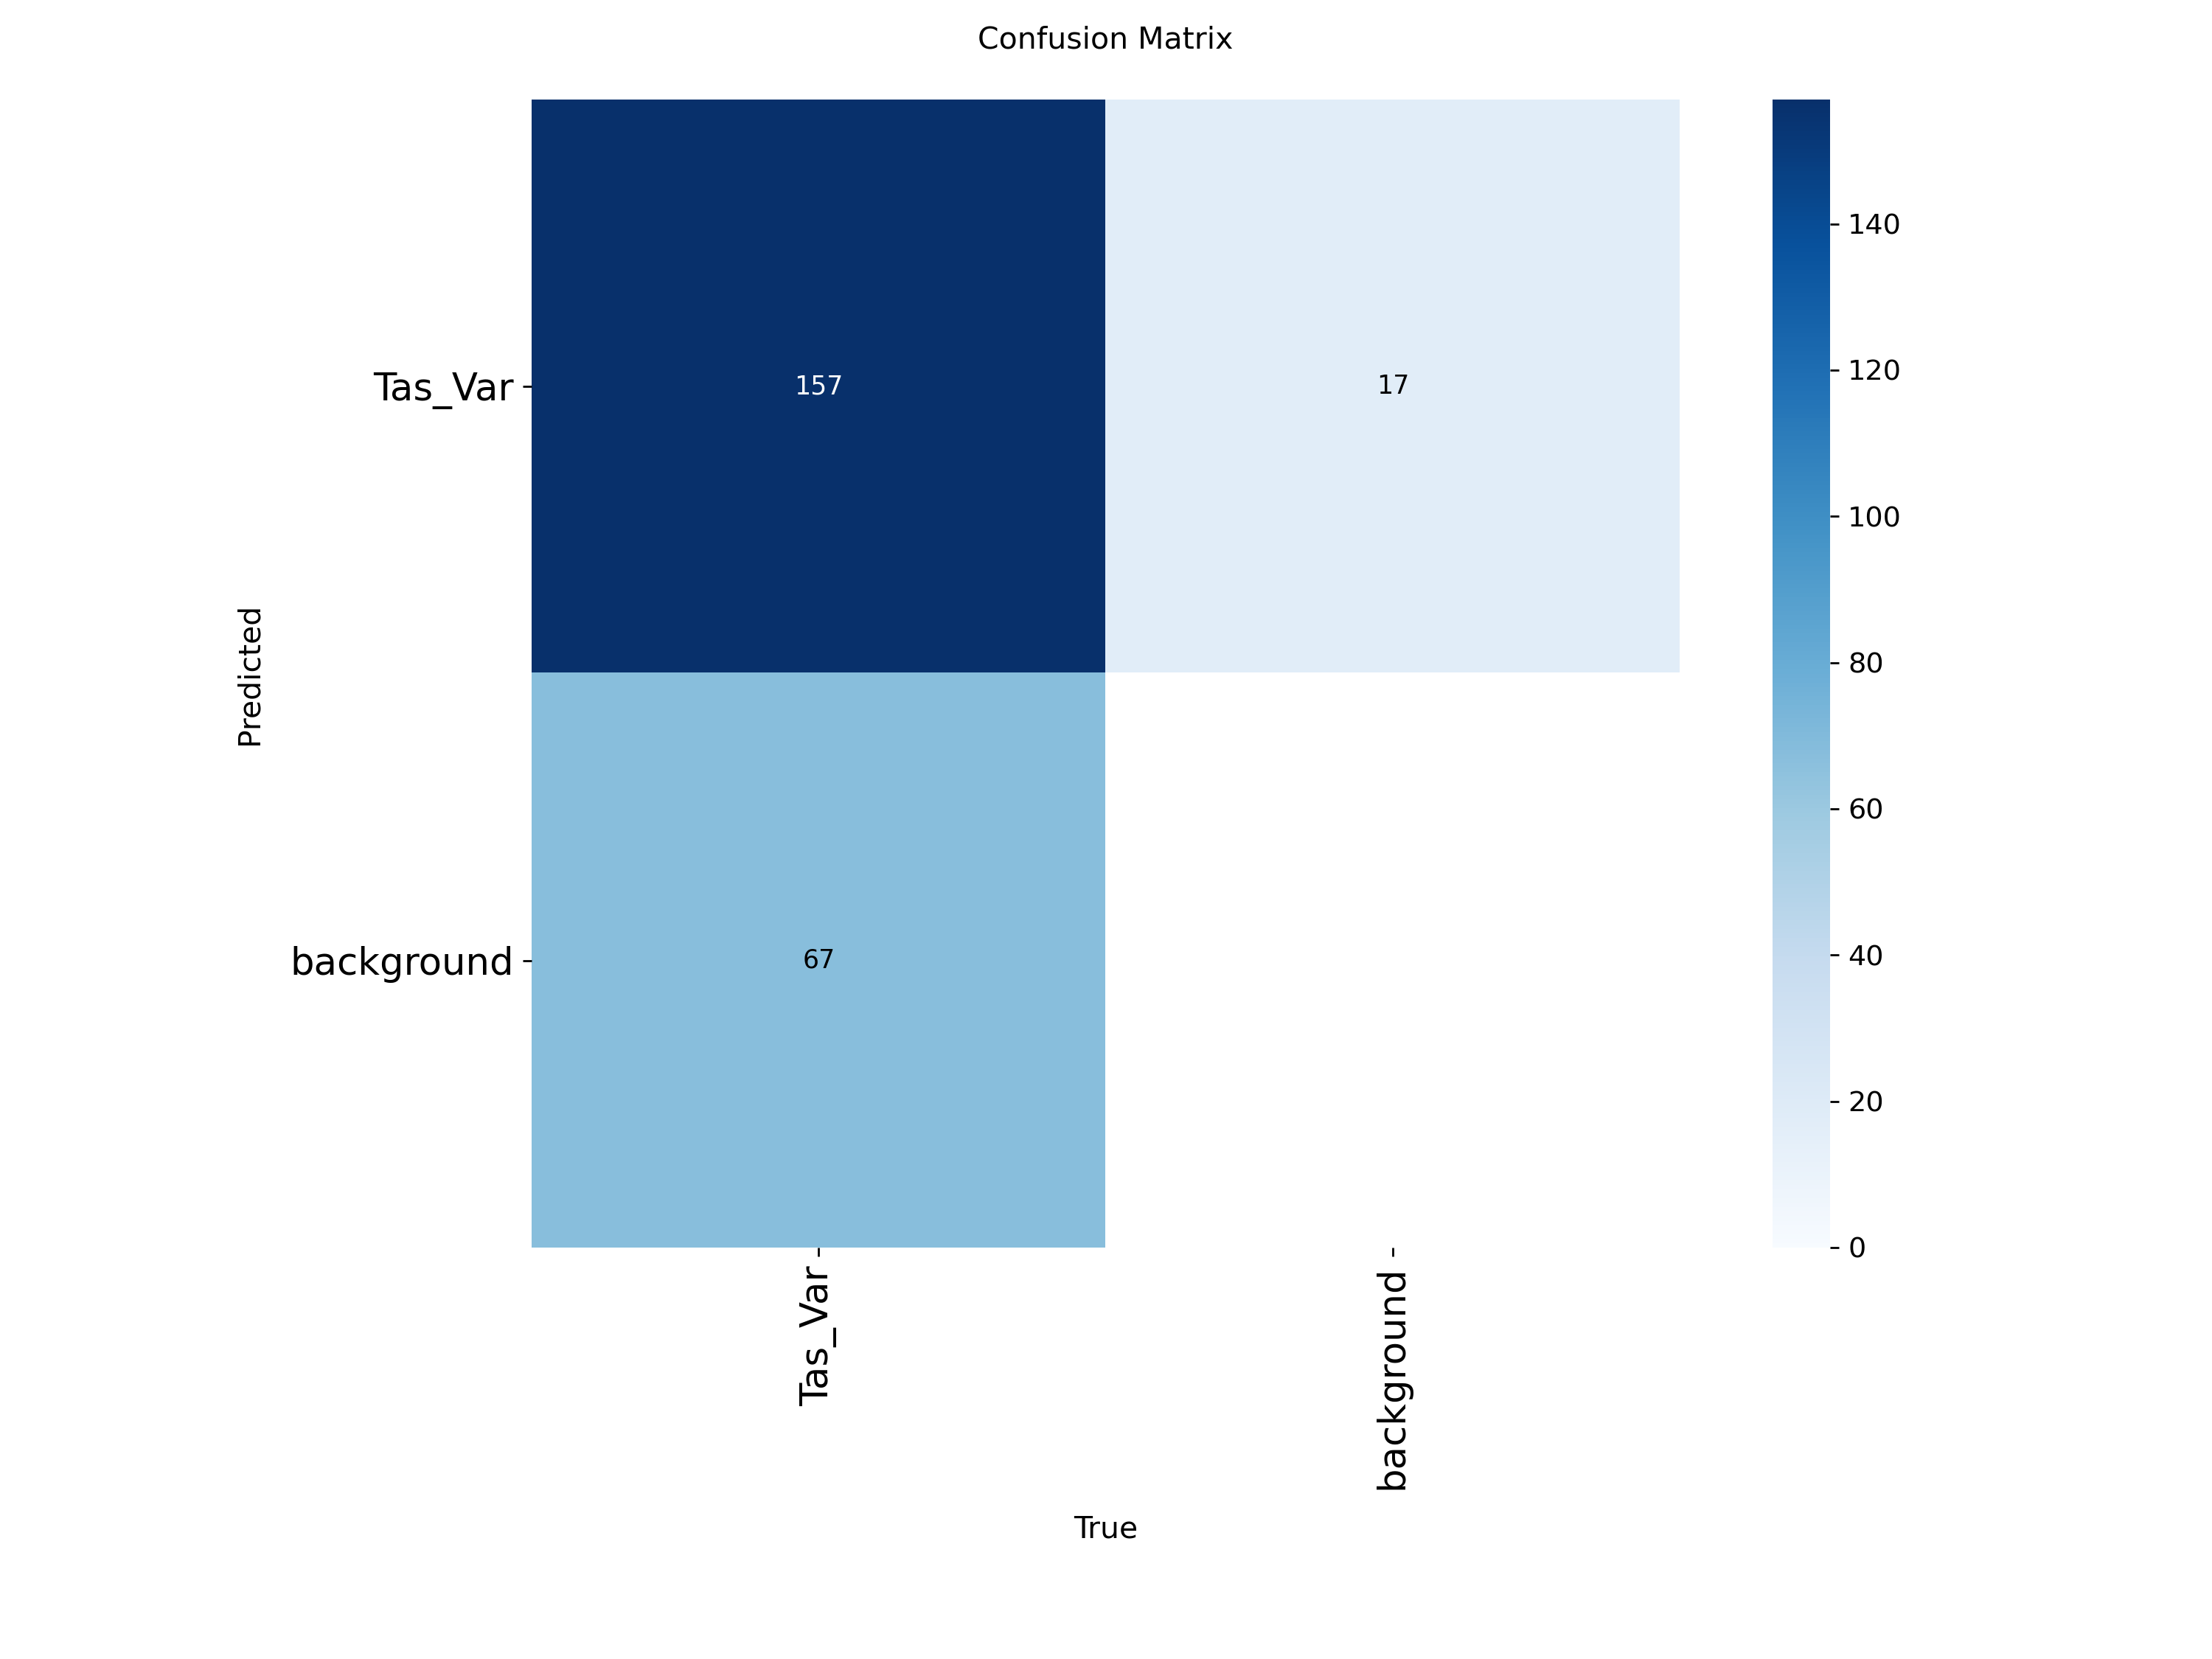

In [13]:
from IPython.display import Image, display
from pathlib import Path

# Ruta al directorio donde se guardaron los resultados de validación
val_dir = Path("/content/runs/detect/val15")  # <-- ajusta si usaste otro nombre de carpeta

# Mostrar matriz de confusión si existe
conf_matrix_img = val_dir / "confusion_matrix.png"
if conf_matrix_img.exists():
    display(Image(filename=str(conf_matrix_img)))
else:
    print("No se encontró el archivo 'confusion_matrix.png' en el directorio:", val_dir)


# Evaluación del modelo YOLO – Explicación de parámetros y métricas (con valores obtenidos)

---

## 1. Parámetros usados en la validación (`model.val()`)

| Parámetro | Valor usado | Descripción |
|-----------|-------------|-------------|
| `data` | `data=DATA_YAML` | Archivo que define rutas de `train`, `val`, `test` y las clases. |
| `imgsz` | `768` | Tamaño de entrada (las imágenes se redimensionan a 768×768). |
| `batch` | `16` | Imágenes evaluadas por lote (mayor = más rápido si hay memoria). |
| `device` | `0` | Se usa la GPU 0 (`Tesla T4` en Colab). |
| `split` | `test` | Se evaluó únicamente el conjunto de prueba. |
| `conf` | `0.40` | Umbral mínimo de confianza para aceptar una detección. |
| `iou` | `0.55` | IoU mínimo para considerar una predicción como acierto. |

---

## 2. Métricas principales obtenidas

| Métrica | Valor obtenido | Significado |
|---------|----------------|-------------|
| **Precision** | `0.8736` | 87.36 % de las detecciones fueron correctas (pocos falsos positivos). |
| **Recall** | `0.6786` | 67.86 % de los objetos reales fueron detectados (algunos falsos negativos). |
| **mAP50** | `0.7779` | 77.79 % de precisión media a IoU ≥ 0.50 (métrica estándar en detección). |
| **mAP50-95** | `0.3717` | 37.17 % de precisión media entre IoU 0.50–0.95 (métrica más estricta). |
| **Fitness** | `0.3717` | Valor interno de Ultralytics basado principalmente en mAP50–95. |
| **Tiempo por imagen** | `pre: 6.8 ms • inferencia: 11.7 ms • post: 1.9 ms` | Velocidad promedio del modelo durante la evaluación. |

---

## 3. Interpretación rápida

| Métrica | Qué indica en este modelo |
|---------|---------------------------|
| Precision alta (0.87) | El modelo rara vez marca una piedra cuando no la hay. |
| Recall medio (0.68) | Detecta la mayoría, pero todavía deja pasar algunos casos. |
| mAP50 ≈ 0.78 | Buen desempeño general según la métrica estándar. |
| mAP50-95 ≈ 0.37 | El ajuste de las cajas podría mejorar (más exigente que mAP50). |

---

## 4. Relación entre `conf` y el resultado obtenido

| Umbral `conf` | Efecto | Observación en tu modelo |
|---------------|--------|--------------------------|
| Bajo (≤ 0.10) | Más recall, menos precision | Detectaba más, pero aumentaban falsos positivos. |
| Medio (0.35–0.45) | Equilibrio | 0.40 dio el mejor balance `P=0.87 / R=0.68`. |
| Alto (≥ 0.60) | Mucha precision, poca recall | Se pierden detecciones (recall cae drásticamente). |

---

## 5. Qué penaliza cada métrica

| Métrica | Penaliza más | Aplicación típica |
|---------|--------------|-------------------|
| Precision | Falsos positivos | Diagnóstico, control de calidad |
| Recall | Falsos negativos | Seguridad, medicina, detección crítica |
| mAP50 | Balance general | Competencias, papers, benchmarks |
| mAP50-95 | Localización precisa | Modelos avanzados / ajuste fino |

---

## 6. ¿Por qué mAP50-95 = 0.37 si mAP50 = 0.78?

- mAP50 solo requiere un IoU ≥ 0.50.
- mAP50-95 exige IoU ≥ 0.50, 0.55, 0.60… hasta 0.95.
- Si las cajas detectan el objeto pero no están bien ajustadas, baja esta métrica.
- Esto indica que el modelo **detecta**, pero podría mejorar la precisión del bounding box.

---

## 7. Resumen final del desempeño

Modelo: yolov8s_kidney_img768
Configuración evaluada: conf=0.40, iou=0.55, imgsz=768
Resultado: Alta precision, recall moderado, buen mAP50, mAP50-95 mejorable


> Conclusión: el modelo es fiable en cuanto a no producir falsos positivos, pero todavía puede mejorar la cobertura (recall) y el ajuste de las cajas (mAP50-95).

---
